In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import rioxarray

pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

In [2]:
import geopandas as gpd
from deafrica_tools.spatial import xr_rasterize
serengeti = gpd.read_file('data/serengeti.geojson')
serengeti = serengeti.to_crs('epsg:21036')
serengeti
#mask = xr_rasterize(serengeti[serengeti['ID'] == 0], ds_rf)

#mask the rainfall dataset
#ds_rf = ds_rf.where(mask)

# Plot the mask
#mask.plot()

,ID,AREA,PERIMETER,ACRES,HECTARES,NAME,Status,Protection,geometry
0,0,654692200.0,177073.1,0.0,0.0,Lemek,Group Ranch,Buffer,"MULTIPOLYGON (((496436.722 9767480.112, 496433..."


In [5]:
# Open the NetCDF file using xarray
#ds = xr.open_dataset('data/Serengeti_tamsat.nc')
ds = xr.open_dataset('data/serengeti_chirps.nc')
ds = ds.sel(time=slice('2015-01', '2022-09'))
ds

<xarray.Dataset>
Dimensions:      (time: 2800, y: 103, x: 88)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01T11:59:59.500000 ... 2022-09...
  * y            (y) float64 9.992e+06 9.988e+06 ... 9.488e+06 9.482e+06
  * x            (x) float64 4.925e+05 4.975e+05 ... 9.225e+05 9.275e+05
    spatial_ref  int32 ...
Data variables:
    rainfall     (time, y, x) float32 ...
Attributes:
    crs:           epsg:21036
    grid_mapping:  spatial_ref

In [4]:
ds.rio.set_spatial_dims('y','x',inplace=True)
ds.rio.write_crs('EPSG:4326',inplace=True)
ds = ds.rio.reproject("EPSG:21036")
ds

CPLE_AppDefinedError: Too many points (441 out of 441) failed to transform, unable to compute output bounds.

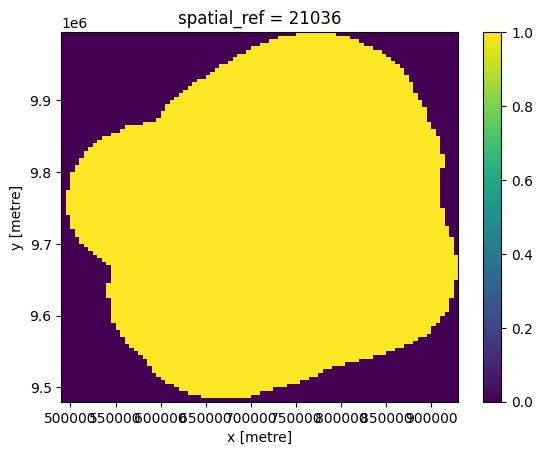

In [6]:
mask = xr_rasterize(serengeti[serengeti['ID'] == 0], ds)

#mask the rainfall dataset
ds = ds.where(mask)

# Plot the mask
mask.plot()

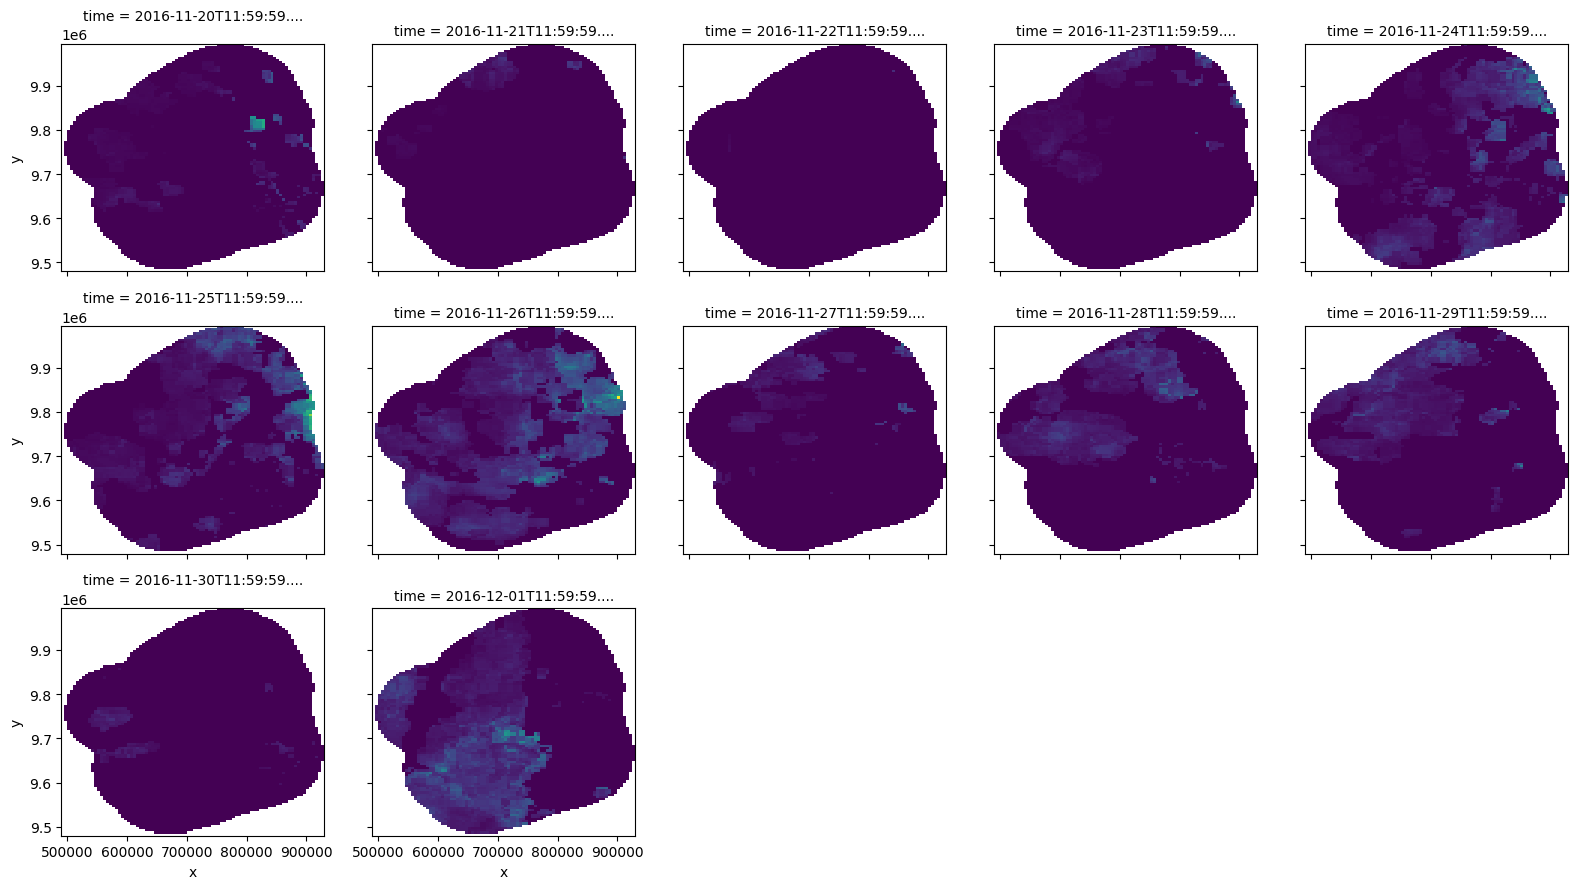

In [11]:
ds.rainfall.sel(time=slice('2016-11-20', '2016-12-01')).plot(col='time', col_wrap=5, add_colorbar=False )

In [7]:
# Define the threshold value
threshold = 0.0

# Find the time, latitude, and longitude when rainfall is above the threshold
#ds_masked = ds['rfe'].where(ds['rfe'] > threshold, drop=True)
ds_masked = ds['rainfall'].where(ds['rainfall'] > threshold, drop=True)
ds_masked

<xarray.DataArray 'rainfall' (time: 2710, y: 102, x: 87)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01T11:59:59.500000 ... 2022-09...
  * y            (y) float64 9.992e+06 9.988e+06 ... 9.492e+06 9.488e+06
  * x            (x) float64 4.975e+05 5.025e+05 ... 9.225e+05 9.275e+05
    spatial_ref  int32 21036
Attributes:
    units:         mm
    nodata:        -9999
    crs:           epsg:21036
    grid_mapping:  spatial_ref

In [8]:
file = "data/Serengeti_all.csv"
dfa = pd.read_csv(file, dtype=None)

dfa['time1'] = pd.to_datetime(dfa['t1_'])
dfa['date1'] = pd.to_datetime(dfa['time1'].dt.date)
dfa['time2'] = pd.to_datetime(dfa['t2_'])
dfa['date2'] = pd.to_datetime(dfa['time2'].dt.date)

# Subset the DataFrame by the date range
dfa.set_index('date1', inplace=True)
dfa = dfa.sort_index()
#df = df['2013-11-11':'2013-11-16']

/tmp/ipykernel_429056/85174987.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('magma', len(unique_ids))


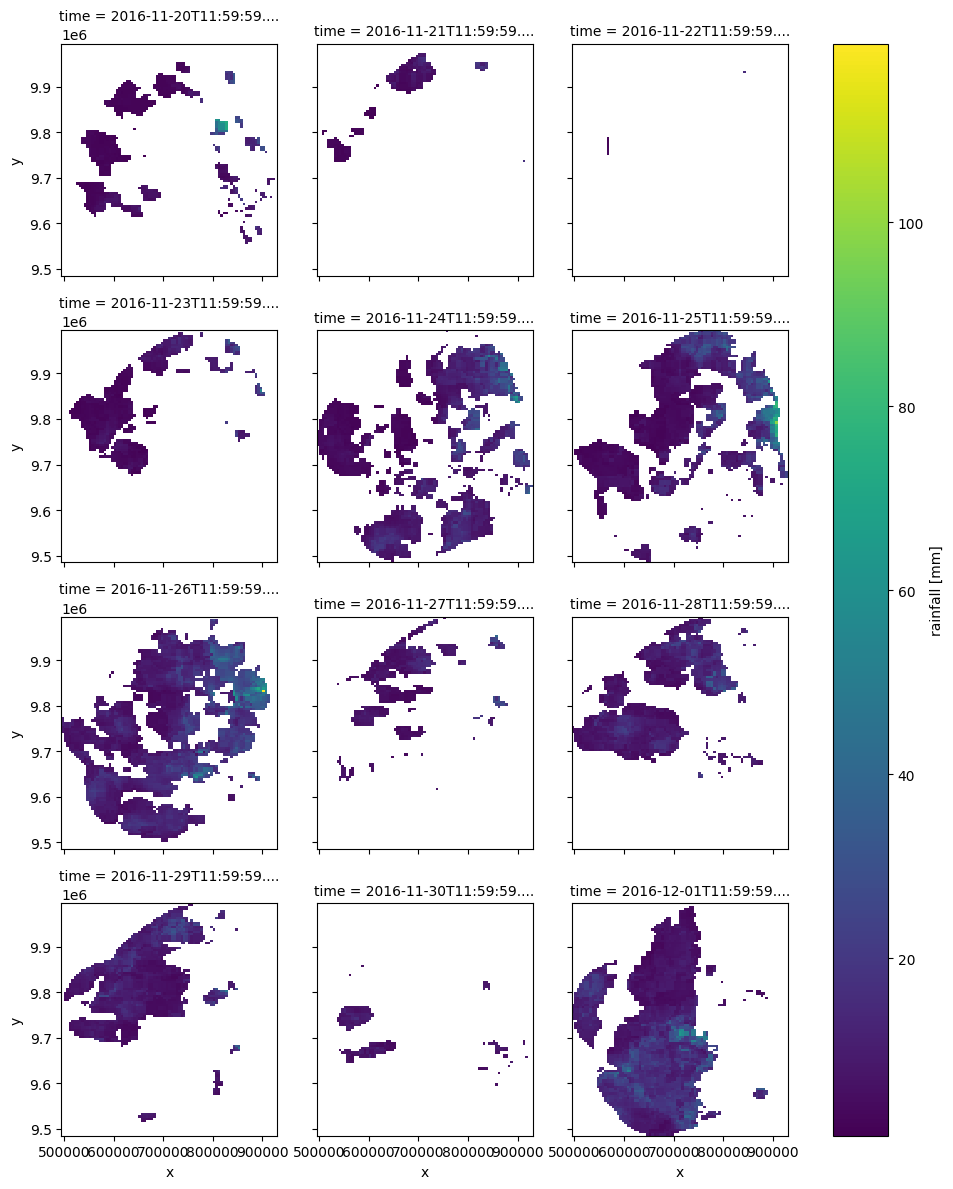

In [14]:
from matplotlib.patches import FancyArrowPatch

dfs = dfa['2016-11-20':'2016-12-01']
dm = ds_masked.sel(time=slice('2016-11-20', '2016-12-01'))
dm.plot(col='time', col_wrap=3 )

# Get the list of axes from the xarray subplot grid
axes = plt.gcf().get_axes()

# Extract unique IDs from the GPS data
unique_ids = dfs['ID'].unique()

# Define a mapping between IDs and colors
id_color_map = {}
colors = plt.cm.get_cmap('magma', len(unique_ids))

for i, id in enumerate(unique_ids):
    id_color_map[id] = colors(i)

# Overlay GPS data on each subplot, coloring by ID and case_
for i, ax in enumerate(axes):
    if i < len(dm['time']):  # Check if the index is within bounds
        # Extract the time for the current subplot
        current_time = dm['time'][i].values
        
        # Filter GPS data for the current time using .loc
        gps_data_subset = dfs.loc[dfs.index == current_time]
        
        # Iterate over unique IDs and plot each group with a unique color
        for id in unique_ids:
            id_subset = gps_data_subset[gps_data_subset['ID'] == id]
            color = id_color_map[id]
            # Separate the data based on 'case_' values
            case_true_data = id_subset[id_subset['case_']]
            case_false_data = id_subset[~id_subset['case_']]
            # Plot the first set of X and Y data (x1_ and y1_) with different colors
            ax.scatter(case_true_data['x1_'], case_true_data['y1_'], color=color, label=f'ID {id} (Case True)', s=20)
            #ax.scatter(case_false_data['x1_'], case_false_data['y1_'], color=color, label=f'ID {id} (Case False)', s=20)
            # Plot the second set of X and Y data (x2_ and y2_) with different colors
            ax.scatter(case_true_data['x2_'], case_true_data['y2_'], color=color, s=20)
            #ax.scatter(case_false_data['x2_'], case_false_data['y2_'], color=color, s=20)
            # Connect the points with lines for both sets of data
            for index, row in case_true_data.iterrows():
                ax.add_patch(FancyArrowPatch((row['x1_'], row['y1_']), (row['x2_'], row['y2_']),
                                             arrowstyle='->', color=color, mutation_scale=10))
            #for index, row in case_false_data.iterrows():
                #ax.add_patch(FancyArrowPatch((row['x1_'], row['y1_']), (row['x2_'], row['y2_']),
                                             #arrowstyle='->', color='grey', mutation_scale=15))
        
        # Set the x and y axis limits for zooming
        #ax.set_xlim(596742, 821598)
        #ax.set_ylim(9608997.0, 9879023)
        #ax.legend()
        #ax.set_title(f'GPS Data Overlay at Time {current_time}')

# Show the plot
plt.show()


In [12]:
## datasets for cloud calculation
df = dfa.reset_index()
rain = ds_masked.to_dataframe().reset_index()
rain = rain.dropna()
rain['date'] = pd.to_datetime(rain['time'].dt.date)

subset the data for 2 months

In [10]:
dfs = dfa['2016-10-01':'2016-11-30']
dm = ds_masked.sel(time=slice('2016-10-01', '2016-11-30'))
df = dfs.reset_index()
rain = dm.to_dataframe().reset_index()
rain = rain.dropna()
rain['date'] = pd.to_datetime(rain['time'].dt.date)

# Find best cloud pixel based on distance and estimated rainfall

In [19]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from tqdm import tqdm  # Import tqdm for the progress bar

# Set up tqdm for the loop
tqdm.pandas()

def calculate_angle(row):
    trajectory_vector = np.array([row['x2_'] - row['x1_'], row['y2_'] - row['y1_']])
    cloud_vector = np.array([row['best_pixel_x'] - row['x1_'], row['best_pixel_y'] - row['y1_']])
    
    dot_product = np.dot(trajectory_vector, cloud_vector)
    norm_product = np.linalg.norm(trajectory_vector) * np.linalg.norm(cloud_vector)
    cloud_dist = np.linalg.norm(cloud_vector)
    
    cloud_angle = np.arccos(dot_product / norm_product)
    cos_cloud_angle = np.cos(cloud_angle)

    return dot_product, cloud_angle, cos_cloud_angle, cloud_dist

# Create a progress bar for the loop
for index, gps_row in tqdm(df.iterrows(), total=len(df), desc="Processing GPS Data"):
    # 1. Find corresponding date in rainfall DataFrame
    date = gps_row['date1']
    rainfall_date = rain[rain['date'] == date]

    # 2. Subset the rainfall data for that specific date
    rainfall_subset = rainfall_date.copy()

    # 3. Calculate distance between GPS location and each pixel
    gps_location = np.array([gps_row['x1_'], gps_row['y1_']])
    rainfall_subset['distance'] = cdist(rainfall_subset[['x', 'y']], [gps_location],'euclidean')/1000

    # 4. Score each pixel based on the criteria
    # Use the reciprocal of the distance as the weight for scoring
    rainfall_subset['weight'] = 1 / rainfall_subset['distance']
    #rainfall_subset['score'] = rainfall_subset['rfe'] * rainfall_subset['weight']
    rainfall_subset['score'] = rainfall_subset['rainfall'] * rainfall_subset['weight']

    # 5. Check if there are valid pixels in rainfall_subset
    if not rainfall_subset.empty:
        # 6. Find the pixel with the highest score
        best_pixel = rainfall_subset.loc[rainfall_subset['score'].idxmax()]

        # 7. Add the corresponding rainfall estimate to your GPS DataFrame
        #df.at[index, 'best_rainfall'] = best_pixel['rfe']
        df.at[index, 'best_rainfall'] = best_pixel['rainfall']
        df.at[index,'rain_date'] = best_pixel['date']

        # 8. Add the location of the best pixel to your GPS DataFrame
        df.at[index, 'best_pixel_x'] = best_pixel['x']
        df.at[index, 'best_pixel_y'] = best_pixel['y']

    else:
        # Handle the case where rainfall_subset is empty (no valid pixels for the given date)
        # You might want to set some default values or handle it in a way that makes sense for your use case
        df.at[index, 'best_rainfall'] = np.nan
        df.at[index, 'best_pixel_x'] = np.nan
        df.at[index, 'best_pixel_y'] = np.nan
        
# Create a progress bar for the loop
for index, gps_row in tqdm(df.iterrows(), total=len(df), desc="Processing turning angle"):
    # 9. Calculate angles and distance
    dot_product, cloud_angle, cos_cloud_angle, cloud_dist = calculate_angle(gps_row)
    df.at[index, 'dot_product'] = dot_product
    df.at[index, 'cloud_angle'] = cloud_angle
    df.at[index, 'cos_cloud_angle'] = cos_cloud_angle
    df.at[index, 'cloud_dist'] = cloud_dist
        

Processing turning angle: 100%|██████████| 695310/695310 [01:18<00:00, 8809.81it/s] 


In [ ]:
## Plot the nearest cloud of different thresholds
from matplotlib.patches import FancyArrowPatch

#dfs = df['2013-11-20':'2013-11-27']
dfd = df
#dfd.set_index('date1', inplace=True)
dfd = dfd['2016-11-20':'2016-11-27']
dfd = dfd[dfd['ID'] == 'SW37']
#dfd.set_index('date1', inplace=True)
dm = ds_masked.sel(time=slice('2016-11-20', '2016-11-27'))
dm.plot(col='time', col_wrap=2 )
#dfcloud = df

# Get the list of axes from the xarray subplot grid
axes = plt.gcf().get_axes()

# Extract unique IDs from the GPS data
#unique_ids = dfs['ID'].unique()
unique_ids = df['ID'].unique()

# Define a mapping between IDs and colors
id_color_map = {}
colors = plt.cm.get_cmap('magma', len(unique_ids))

for i, id in enumerate(unique_ids):
    id_color_map[id] = colors(i)

# Overlay GPS data on each subplot, coloring by ID and case_
for i, ax in enumerate(axes):
    if i < len(dm['time']):  # Check if the index is within bounds
        # Extract the time for the current subplot
        current_time = dm['time'][i].values
        
        # Filter GPS data for the current time using .loc
        #gps_data_subset = dfs.loc[dfs.index == current_time]
        gps_data_subset = dfd.loc[dfd.index == current_time]
        
        # Iterate over unique IDs and plot each group with a unique color
        for id in unique_ids:
            id_subset = gps_data_subset[gps_data_subset['ID'] == id]
            color = id_color_map[id]
            # Separate the data based on 'case_' values
            case_true_data = id_subset[id_subset['case_']]
            case_false_data = id_subset[~id_subset['case_']]
            # Plot the first set of X and Y data (x1_ and y1_) with different colors
            ax.scatter(case_true_data['x1_'], case_true_data['y1_'], color='yellow', label=f'ID {id} (Case True)', s=20)
            #ax.scatter(case_false_data['x1_'], case_false_data['y1_'], color=color, label=f'ID {id} (Case False)', s=20)
            # Plot the second set of X and Y data (x2_ and y2_) with different colors
            ax.scatter(case_true_data['x2_'], case_true_data['y2_'], color='yellow', s=20)
            #ax.scatter(case_false_data['x2_'], case_false_data['y2_'], color=color, s=20)
            ax.scatter(case_true_data['best_pixel_x'], case_true_data['best_pixel_y'], color='red', s=20)
            #ax.scatter(case_true_data['cloud_8mm_x'], case_true_data['cloud_8mm_y'], color='green', s=20)
            #ax.scatter(case_true_data['cloud_10mm_x'], case_true_data['cloud_10mm_y'], color='yellow', s=20)
            #ax.scatter(case_true_data['cloud4_x'], case_true_data['cloud4_y'], color='orange', s=20)
            #ax.scatter(case_true_data['cloud5_x'], case_true_data['cloud5_y'], color='brown', s=20)
            # Connect the points with lines for both sets of data
            for index, row in case_true_data.iterrows():
                ax.add_patch(FancyArrowPatch((row['x1_'], row['y1_']), (row['x2_'], row['y2_']),
                                             arrowstyle='->', color=color, mutation_scale=10))
            #for index, row in case_false_data.iterrows():
                #ax.add_patch(FancyArrowPatch((row['x1_'], row['y1_']), (row['x2_'], row['y2_']),
                                             #arrowstyle='->', color='grey', mutation_scale=15))
        # Set the x and y axis limits for zooming
        #ax.set_xlim(596742, 821598)
        #ax.set_ylim(9608997.0, 9879023)
        #ax.legend()
        #ax.set_title(f'GPS Data Overlay at Time {current_time}')

# Show the plot
plt.show()


In [3]:
import pandas as pd
file = "data/Serengeti_all.csv"
dfa = pd.read_csv(file, dtype=None)
dfa = dfa[dfa['ID'] == 'SW40']
dfa.to_csv('data/Serengeti_SW40.txt', index=False)

In [ ]:
df.to_csv('data/Serengeti_chirps_dataset.csv', index=False)

In [ ]:
rain.tail(50)

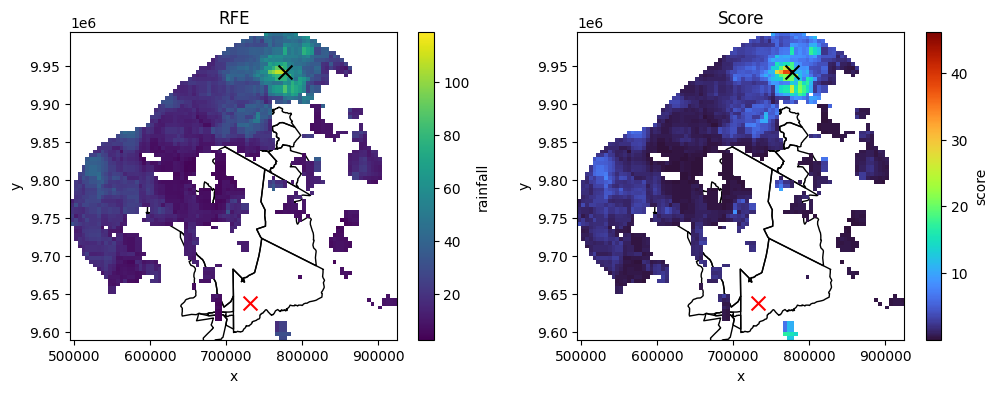

In [17]:
import geopandas as gpd
from shapely.geometry import Point

# Load Serengeti shapefile
serengeti_shapefile = gpd.read_file('data/shapefile/v4_serengeti_ecosystem.shp')

# 1. Find corresponding date in rainfall DataFrame
rainfall_date = rain[rain['date'] == '2016-05-06'-2]

# 2. Subset the rainfall data for that specific date
rainfall_subset = rainfall_date.copy()

# 3. Calculate distance between GPS location and each pixel
gps_location = [731933.8,9638418]
rainfall_subset['distance'] = cdist(rainfall_subset[['x', 'y']], [gps_location],'euclidean')/1000

# 4. Score each pixel based on the criteria
# Use the reciprocal of the distance as the weight for scoring
#rainfall_subset['weight'] = 1 / rainfall_subset['distance']**2

# Adjust the power factor according to the desired emphasis on 'rfe'
power_factor = 2

# Calculate the score with more power to 'rfe'
rainfall_subset['score'] = rainfall_subset['rainfall'] ** power_factor / rainfall_subset['distance']

# Calculate the weighted score
#rainfall_subset['score'] = rainfall_subset['rainfall'] * rainfall_subset['weight']

# 5. Convert the DataFrame to xarray.Dataset
ds = xr.Dataset.from_dataframe(rainfall_subset.set_index(['time', 'y', 'x']))

# 6. Plot 'score' and 'rfe' variables next to each other
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot Serengeti polygon
serengeti_shapefile.plot(ax=axes[0], color='none', edgecolor='black', linewidth=1, alpha=1)
serengeti_shapefile.plot(ax=axes[1], color='none', edgecolor='black', linewidth=1, alpha=1)

# Plot 'score'
ds.score.plot(ax=axes[1], cmap='turbo')
axes[1].set_title('Score')

# Find the index of the maximum score
max_score_location = ds.where(ds.score == ds.score.max(), drop=True).coords

# Add a point for gps_location on the 'score' plot
axes[0].scatter(gps_location[0], gps_location[1], color='red', marker='x', s=100)#, label='GPS Location')
#axes[0].legend()

# Plot 'rfe'
ds.rainfall.plot(ax=axes[0], cmap='viridis')
axes[0].set_title('RFE')

# Add an 'x' marker at the location of the maximum score
axes[0].scatter(max_score_location['x'], max_score_location['y'], color='black', marker='x', s=100)#, label='Max Score')
#axes[0].legend()

# Add an 'x' marker at the location of the maximum score
axes[1].scatter(max_score_location['x'], max_score_location['y'], color='black', marker='x', s=100)#, label='Max Score')
#axes[1].legend()

# Add a point for gps_location on the 'rfe' plot
axes[1].scatter(gps_location[0], gps_location[1], color='red', marker='x', s=100)#, label='GPS Location')
#axes[1].legend()

plt.show()

